# Datawrangling - Capstone 1
***

## Beer Review Data Description
***

The dataset we have contains over 1.5 million reviews of various beers from two websites: BeerAdvocate.com. This data not only includes user reviews, product category and alcohol by volume(ABV), but sensory aspects as well such as taste, look, smell and overall ratings. For this project we will train and test models to predict beer ratings and beer style based of the user reviews that were left.

These reviews were made available by Julian Mcauley, a UCSD Computer Science professor, from a collection period of January 1998 to November 2011. This dataset was accessed with permssion. Here are some key specs of the dataset itself.
+ Number of users: 33,387
+ Number of items: 66,051
+ Number of reviews: 1,586,259
    
To tackle the issue of size, we will take a subset sample of 99,999 reviews to train and test our models before applying it to the rest of the dataset.


### Import and Review Data
***

In [30]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import TextBlob

In [2]:
beersmall = pd.read_excel('data/ratebeer_sample.xlsx')

In [3]:
beersmall.head()

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,time,profileName,text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,3,6,13,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,4,7,13,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4,5,3,6,14,958694400,PhillyBeer2112,"Springfield, PA. I've never had the Budvar Cri..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,K•À_lsch,2,4,2,4,8,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,K•À_lsch,2,4,2,4,8,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
beersmall.columns

Index(['name', 'beerId', 'brewerId', 'ABV', 'style', 'appearance', 'aroma',
       'palate', 'taste', 'overall', 'time', 'profileName', 'text'],
      dtype='object')

In [5]:
beersmall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 13 columns):
name           99999 non-null object
beerId         99999 non-null object
brewerId       99999 non-null int64
ABV            99999 non-null object
style          99999 non-null object
appearance     99999 non-null int64
aroma          99999 non-null int64
palate         99999 non-null int64
taste          99999 non-null int64
overall        99999 non-null int64
time           99999 non-null int64
profileName    99999 non-null object
text           99999 non-null object
dtypes: int64(7), object(6)
memory usage: 9.9+ MB


## Examining and Cleaning the DataFrame 
***
Examining the first few columns of the dataframe you can notice a few things
+ Special characters and notation weren't read properly. We need to fix this somehow.
+ There is a time column that if we would want to use needs to be altered. In this case we don't need it, so we will drop it.
+ Beers have a range of reviews from 1 to x amount. We want beers to have at least 5 reviews so we need to remove the ones that have less
+ Some beers don't have an alcohol percentage (ABV)
+ Index needs to be redone.
+ The rating system is not on the same scale. "Aroma" and "Taste" ratings are on a scale of 10 while, the rest are on a scale of 5. 
***
### Remove Unecessary Data

In [6]:
# Drop Time Column
beersmall = beersmall.drop(['time'], axis=1)

In [7]:
# Drop any beer styles that have less than 5 reviews
id_count = beersmall.groupby('style')['style'].transform(len)
mask = id_count > 5
beersmall = beersmall[mask]

# Drop any beer names that have less than 5 reviews
id_count = beersmall.groupby('name')['name'].transform(len)
mask = id_count > 5
beersmall = beersmall[mask]

### Fix Spelling Errors

In [8]:
# Check for Beer Styles where the name needs to be altered.
beersmall['style'].unique()

array(['Imperial/Double IPA', 'Sour Ale/Wild Ale', 'Traditional Ale',
       'India Pale Ale &#40;IPA&#41;', 'Brown Ale', 'Porter',
       'Belgian White &#40;Witbier&#41;', 'Imperial Stout', 'Sweet Stout',
       'Stout', 'Scotch Ale', 'Saison', 'American Pale Ale',
       'Belgian Strong Ale', 'Wheat Ale', 'Abt/Quadrupel', 'Premium Lager',
       'Imperial/Strong Porter', 'Pale Lager', 'Fruit Beer',
       'English Pale Ale', 'Spice/Herb/Vegetable', 'Amber Ale', 'Pilsener',
       'Premium Bitter/ESB', 'Vienna', 'Barley Wine', 'Doppelbock',
       'Altbier', 'Abbey Tripel', 'Classic German Pilsener', 'Weizen Bock',
       'Dunkelweizen', 'Oktoberfest/M•À_rzen', 'Dortmunder/Helles',
       'Zwickel/Keller/Landbier', 'German Hefeweizen', 'Sak•À_ - Junmai',
       'Sak•À_ - Nigori', 'Sak•À_ - Daiginjo',
       'Strong Pale Lager/Imperial Pils', 'Dunkel', 'Heller Bock',
       'Golden Ale/Blond Ale', 'Scottish Ale', 'Mild Ale', 'Irish Ale',
       'California Common', 'Dunkler Bock', 'Lo

In [9]:
# Function to replace character errors in the style column
def replacestyle(col):
    # Replace each value that matches the left side of the pair
    return col.replace({
        'K•À_lsch': 'Kölsch',
        '&#40;' : '(',
        '&#41;' : ')',
        'M•À_rzen' : 'Märzen',
        'Sak•À_' : 'Sake',
        'Bi•À_re de Garde' : 'Bière de Garde'
    }, regex=True)

# Apply the function replacestyle to the beer['style'] column
beersmall['style'] = replacestyle(beersmall['style'])

# Function to replace character errors in the name column 
def replacename(col):
    # Replace each value that matches the left side of the pair
    return col.replace({
        '&quot;' : '"', 
        '&#40;' : '(',
        '&#41;' : ')',
        'Brï¿½u' : 'Bräu',
        'Kï¿½r' : 'Kür',
        'Mï¿½r' : 'Mär',
        'hï¿½f' : 'häf',
        'lï¿½n' : 'lán',
        'gï¿½u' : 'gäu',
        'rï¿½n' : 'rän',
        'tï¿½c' : 'tüc'
    }, regex= True)

# Apply the function replacename to the beer.name column
beersmall.name = replacename(beersmall.name)

### Adjust Rating Scales
***
In order to have all the ratings on the same scale, we will adjust the "aroma" and "taste" rating scales from a scale of 10 to a scale of 5. In addition, the "overall" scale appears to be representative of the other 4 rating values combined on a scale of 20. We will adjust this scale down to a scale of 5 as well.

In [33]:
beersmall['aroma'] = round(beersmall['aroma'] / 2).astype(int)
beersmall['taste'] = round(beersmall['taste'] / 2).astype(int)
beersmall['overall'] = (beersmall['appearance'] + beersmall['aroma'] + beersmall['palate'] + beersmall['taste']) / 4

In [34]:
beersmall.head()

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,profileName,text,word_count,char_count,avg_word_len,stop_words,upper,clean_text
15,Barley Island Barrel-Aged Count Hopula,91592,3228,8,Imperial/Double IPA,4,1,4,1,2.5,JJClark,Handbottled from trade wth Sprinkle. Pours a n...,60,346.0,4.783333,18,0,handbottled trade wth sprinkle pours dark copp...
16,Barley Island Barrel-Aged Count Hopula,91592,3228,8,Imperial/Double IPA,4,1,4,1,2.5,CaptainCougar,On tap at the Great Taste of the Midwest (8/9/...,66,381.0,5.015873,18,0,tap great taste midwest 8908 pours transparent...
17,Barley Island Barrel-Aged Count Hopula,91592,3228,8,Imperial/Double IPA,3,1,3,1,2.0,StFun,"On tap. Interesting experiment, but I liked re...",64,378.0,4.921875,23,2,tap interesting experiment liked regular hopul...
18,Barley Island Barrel-Aged Count Hopula,91592,3228,8,Imperial/Double IPA,4,0,4,0,2.0,MI2CA,On cask at BI - Aroma of the Hopula Play-Doh h...,62,318.0,4.431034,22,2,cask bi hopula playdoh lots oak vanilla bourbo...
19,Barley Island Barrel-Aged Count Hopula,91592,3228,8,Imperial/Double IPA,3,1,3,1,2.0,vyvvy,GTMW 08 on cask - Pours bronze orang with a mi...,67,349.0,4.564516,22,1,gtmw 08 cask pours bronze orang minimal lots v...


### Break Down and Clean Text Reviews
*** 
Text reviews often times have spelling errors, extraneous words and punctuation that we may not need when analyzing the information. For this reason we are going to break down the reviews to deterimine the quality and quantity of them.

In [12]:
def avg_word_len(sentence):
    words = str(sentence).split()
    return (sum(len(word) for word in words)/len(words))

# Determine the word count for each text review: word_count
beersmall['word_count'] = beersmall['text'].apply(lambda x: len(str(x).split(" ")))

# Determine the character count for each text review: char_count
beersmall['char_count'] = beersmall['text'].str.len() ## this also includes spaces

# Determine the average word length per text review: avg_word_len
beersmall['avg_word_len'] = beersmall['text'].apply(lambda x: avg_word_len(x))

# Determine the number of stop words per text review: stop_words
stop = stopwords.words('english')
beersmall['stop_words'] = beersmall['text'].apply(lambda x: len([x for x in str(x).split() if x in stop]))

# Determine the number of uppercase words per text review: upper
beersmall['upper'] = beersmall['text'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))

beersmall[['text','word_count', 'char_count', 'avg_word_len', 'stop_words', 'upper']].head()

,text,word_count,char_count,avg_word_len,stop_words,upper
15,Handbottled from trade wth Sprinkle. Pours a n...,60,346.0,4.783333,18,0
16,On tap at the Great Taste of the Midwest (8/9/...,66,381.0,5.015873,18,0
17,"On tap. Interesting experiment, but I liked re...",64,378.0,4.921875,23,2
18,On cask at BI - Aroma of the Hopula Play-Doh h...,62,318.0,4.431034,22,2
19,GTMW 08 on cask - Pours bronze orang with a mi...,67,349.0,4.564516,22,1


In [13]:
# Create a new column clean_text where each text review is cleaned to be prepared for sentiment analyses
# Change all characters in each review to lowercase.
beersmall['clean_text'] = beersmall['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# Remove any special characters from each review.
beersmall['clean_text'] = beersmall['clean_text'].str.replace('[^\w\s]','')

# Remove any stop words.
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

# Determine the 10 most frequent words and 10 least frequent words and remove them from each review
freq = pd.Series(' '.join(beersmall['clean_text']).split()).value_counts()[:10]
freq2 = pd.Series(' '.join(beersmall['clean_text']).split()).value_counts()[-10:]
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq2))

beersmall[['text', 'clean_text']].head()

,text,clean_text
15,Handbottled from trade wth Sprinkle. Pours a n...,handbottled trade wth sprinkle pours dark copp...
16,On tap at the Great Taste of the Midwest (8/9/...,tap great taste midwest 8908 pours transparent...
17,"On tap. Interesting experiment, but I liked re...",tap interesting experiment liked regular hopul...
18,On cask at BI - Aroma of the Hopula Play-Doh h...,cask bi hopula playdoh lots oak vanilla bourbo...
19,GTMW 08 on cask - Pours bronze orang with a mi...,gtmw 08 cask pours bronze orang minimal lots v...


### Extract One Beer Style for Training Set
***
By looking at our value counts we determine that within this chunk of the data, it appears that there are the most reviews for India Pale Ales(IPAs) and therefore we will use these reviews as our training set to test our models. In order to do so we must extract the rows from the beer dataframe that only include IPAs. 

In [14]:
beer_ipa = beersmall[beersmall['style'] == 'India Pale Ale (IPA)'] 

In [15]:
beer_ipa.head()

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,profileName,text,word_count,char_count,avg_word_len,stop_words,upper,clean_text
114,Barley Island Barfly IPA,58511,3228,6.5,India Pale Ale (IPA),3,4.0,4,4.0,3.75,adamlangolf,Another quality session IPA. The lowest ABV o...,82,423.0,4.441558,22,6,another quality session ipa lowest abv ipa wou...
115,Barley Island Barfly IPA,58511,3228,6.5,India Pale Ale (IPA),3,3.0,3,4.0,3.25,GG,"Received in a trade with mmm///beer, so thanks...",117,614.0,4.389381,45,0,received trade mmmbeer thanks bro quite actual...
116,Barley Island Barfly IPA,58511,3228,6.5,India Pale Ale (IPA),3,4.0,4,4.0,3.75,mar,bottle thanks to mmm///beer. deep ruby color ...,33,175.0,4.766667,7,0,thanks mmmbeer deep ruby color 1 finger cream ...
117,Barley Island Barfly IPA,58511,3228,6.5,India Pale Ale (IPA),4,4.0,3,4.0,3.75,jcwattsrugger,on tap-pours a light tan head that laces and a...,59,377.0,6.000000,15,0,tappours tan laces amber color northwest hopsg...
118,Barley Island Barfly IPA,58511,3228,6.5,India Pale Ale (IPA),3,3.0,3,3.0,3.00,Snojerk321,Bottle via trade with mmm///beer. This brew p...,81,475.0,4.937500,24,0,via trade mmmbeer brew pours thick hazy orange...


We have 7818 reviews for 101 different types of IPAs. We can increase this size by incorporating the rest of the reviews at a later time.
***

# Exploratory Data Analysis

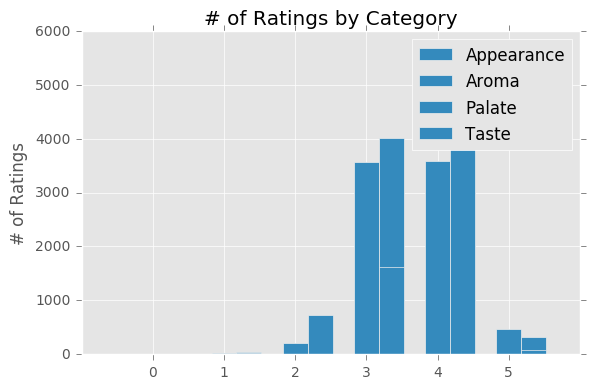

In [55]:
appear_sizes = [len(beer_ipa.appearance[beer_ipa.appearance == 0]), len(beer_ipa.appearance[beer_ipa.appearance == 1]), 
             len(beer_ipa.appearance[beer_ipa.appearance == 2]), len(beer_ipa.appearance[beer_ipa.appearance == 3]),
             len(beer_ipa.appearance[beer_ipa.appearance == 4]), len(beer_ipa.appearance[beer_ipa.appearance == 5])]

aroma_sizes = [len(beer_ipa.aroma[beer_ipa.aroma == 0]), len(beer_ipa.aroma[beer_ipa.aroma == 1]), 
             len(beer_ipa.aroma[beer_ipa.aroma == 2]), len(beer_ipa.aroma[beer_ipa.aroma == 3]),
             len(beer_ipa.aroma[beer_ipa.aroma == 4]), len(beer_ipa.aroma[beer_ipa.aroma == 5])]

palate_sizes = [len(beer_ipa.palate[beer_ipa.palate == 0]), len(beer_ipa.palate[beer_ipa.palate == 1]), 
             len(beer_ipa.palate[beer_ipa.palate == 2]), len(beer_ipa.palate[beer_ipa.palate == 3]),
             len(beer_ipa.palate[beer_ipa.palate == 4]), len(beer_ipa.palate[beer_ipa.palate == 5])]

taste_sizes = [len(beer_ipa.taste[beer_ipa.taste == 0]), len(beer_ipa.taste[beer_ipa.taste == 1]), 
             len(beer_ipa.taste[beer_ipa.taste == 2]), len(beer_ipa.taste[beer_ipa.taste == 3]),
             len(beer_ipa.taste[beer_ipa.taste == 4]), len(beer_ipa.taste[beer_ipa.taste == 5])]

ind = np.arange(len(appear_sizes))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/4, appear_sizes, width,
                label='Appearance')
rects2 = ax.bar(ind + width/4, aroma_sizes, width,
                label='Aroma')

rects3 = ax.bar(ind + width/4, palate_sizes, width,
                label='Palate')

rects4 = ax.bar(ind + width/4, taste_sizes, width,
                label='Ta')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of Ratings')
ax.set_title('# of Ratings by Category')
ax.set_xticks(ind)
ax.set_xticklabels(('0', '1', '2', '3', '4', '5'))
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

In [73]:
def plot_bar_x(rater):
    # this is for plotting purpose
    
    x = ['0', '1', '2', '3', '4', '5']
    sizes = [len(rater[rater == 0]), len(rater[rater == 1]), 
             len(rater[rater == 2]), len(rater[rater == 3]),
             len(rater[rater == 4]), len(rater[rater == 5])]
    
    
    index = np.arange(len(x))
    plt.bar(index, sizes)
    plt.xlabel('Genre', fontsize=5)
    plt.ylabel('No of Movies', fontsize=5)
    plt.xticks(index, x)
    plt.title('Market Share for Each Genre 1995-2017')
    plt.show()

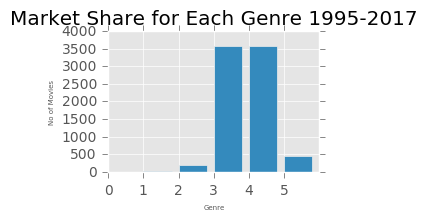

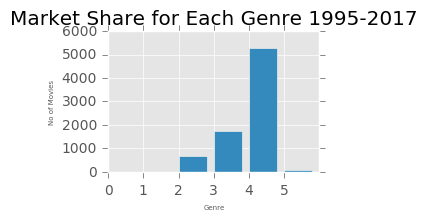

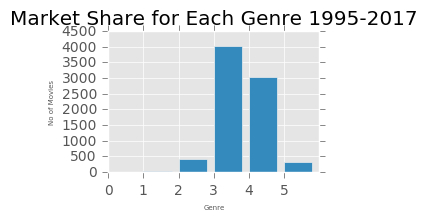

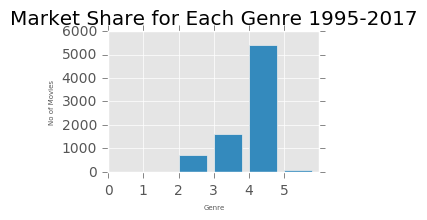

In [78]:
fig = plt.figure()

plt.subplot(2,2,1)
plot_bar_x(beer_ipa.appearance)

plt.subplot(2,2,2)
plot_bar_x(beer_ipa.aroma)

plt.subplot(2,2,3)
plot_bar_x(beer_ipa.palate)

plt.subplot(2,2,4)
plot_bar_x(beer_ipa.taste)


plt.show()

In [80]:
beer_ipa.appearance.value_counts()

4    3577
3    3563
5     465
2     195
1      18
Name: appearance, dtype: int64

In [81]:
beer_ipa.aroma.value_counts()

4.0    5288
3.0    1735
2.0     697
5.0      80
1.0      12
0.0       6
Name: aroma, dtype: int64

In [82]:
beer_ipa.palate.value_counts()

3    4018
4    3034
2     422
5     315
1      29
Name: palate, dtype: int64

In [83]:
beer_ipa.taste.value_counts()

4.0    5385
3.0    1618
2.0     731
5.0      64
1.0      16
0.0       4
Name: taste, dtype: int64



## Sources
***
Lipton, Zachary & Vikram, Sharad & McAuley, Julian. (2015). Capturing Meaning in Product Reviews with Character-Level Generative Text Models.
https://www.researchgate.net/publication/283761921_Capturing_Meaning_in_Product_Reviews_with_Character-Level_Generative_Text_Models